# Solve TSP problem using Genetic Algorithm

## Import libraries

In [8]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

## Model Gen and Chromosome

In [9]:
class City: # Gen in GA
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [10]:
class Route: # Chromosome in GA
    def __init__(self, cities : list):
        self.cities = cities
        self.fitness = 0
        self.distance = 0

    def calculate_distance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.cities)):
                fromCity = self.cities[i]
                toCity = None
                if i + 1 < len(self.cities):
                    toCity = self.cities[i + 1]
                else:
                    toCity = self.cities[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def calculate_fitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.calculate_distance())
        return self.fitness

## GA functions

In [11]:
def create_route(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [12]:
def initial_population(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(create_route(cityList))
    return population

In [13]:
def rank_routes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Route(population[i]).calculate_fitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [14]:
def selection(popRanked, eliteSize, population):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for _ in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break

    mating_pool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        mating_pool.append(population[index])
    return mating_pool

In [17]:
def OX1_crossover(parent1, parent2):
    n = len(parent1)
    index_low = random.randint(0, n-2)
    index_high = random.randint(index_low+1, n-1)
    offspring = [-1 for _ in range(n)]
    offspring[index_low: index_high+1] = parent1[index_low: index_high+1]
    j = (index_high + 1)%n
    if index_low == 0:
        k = index_high
    else:
        k = -1
    for i in range(n):
        if parent2[(i+j)%n] not in parent1[index_low: index_high+1]:
            if k == index_low - 1:
                k = index_high + 1
            else:
                k += 1
            offspring[k] = parent2[(i+j)%n]
    return offspring

In [19]:
def POS_crossover(parent1: list, parent2: list):
    number_of_positions_to_impose = int(random.random() * len(parent1))
    indices = [i for i in range(len(parent1))]
    randome_indices = sorted(random.sample(indices, number_of_positions_to_impose))
    offspring = []
    current_index_of_parent_1 = 0
    i = 0
    selected_cities = [parent2[y] for y in randome_indices]
    while len(offspring) < len(parent1):
        if i in randome_indices:
            offspring.append(parent2[i])
            i += 1
        else:
            if parent1[current_index_of_parent_1] not in selected_cities:
                offspring.append(parent1[current_index_of_parent_1])
                i += 1
            current_index_of_parent_1 += 1
    return offspring

In [20]:
def ER_crossover(parent1: list, parent2: list):
    def get_neighbors(parent, position):
        prev_city = position - 1 if position - 1 >= 0 else len(parent1) - 1
        next_city = position + 1 if position + 1 < len(parent1) else 0
        return [parent[prev_city], parent[next_city]]

    neighbor_list = {}
    for i, city in enumerate(parent1):
        index_in_parent2 = parent2.index(city)
        neighbor_list[city] = set(get_neighbors(parent1, i)+get_neighbors(parent2, index_in_parent2))

    unvisited = set(parent1)
    current_city = parent1[0]
    offspring = [current_city]
    unvisited.remove(current_city)
    while len(offspring) < len(parent1):
        neighbors = neighbor_list[current_city]
        if not len(neighbors):
            if not len(unvisited):
                return offspring
            current_city = unvisited.pop()
            offspring.append(current_city)
            continue
        min_neighbor = None
        min_neighbor_len = len(parent1)
        for neighbor in neighbors:
            neighbor_list[neighbor].remove(current_city)
            if len(neighbor_list[neighbor]) < min_neighbor_len:
                min_neighbor_len = len(neighbor_list[neighbor])
                min_neighbor = neighbor
        current_city = min_neighbor
        offspring.append(current_city)
        unvisited.remove(current_city)
    return offspring

In [21]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [22]:
def breed_population(mating_pool, elite_size, crossover_function):
    children = []
    length = len(mating_pool) - elite_size
    pool = random.sample(mating_pool, len(mating_pool))

    for i in range(0,elite_size):
        children.append(mating_pool[i])

    for i in range(0, length):
        child = crossover_function(pool[i], pool[len(mating_pool)-i-1])
        children.append(child)
    return children

In [23]:
def DM_mutate(individual: list):
    n = len(individual)
    index_low = random.randint(0, n-1)
    index_high = random.randint(index_low, n-1)
    subroute = individual[index_low:index_high+1]
    individual = individual[:index_low] + individual[index_high+1:]
    random_position = random.randint(0, len(individual))
    if random_position == 0:
        individual = subroute + individual
    elif random_position == len(individual):
        individual = individual + subroute
    else:
        individual = individual[:random_position] + subroute + individual[random_position:]
    return individual


In [24]:
def ISM_mutate(individual: list):
    n = len(individual)
    index = random.randint(0, n-1)
    selected_city = individual[index]
    individual = individual[:index] + individual[index+1:]
    random_position = random.randint(0, n-1)
    individual.insert(random_position, selected_city)
    return individual

In [25]:
def IVM_mutate(individual: list):
    n = len(individual)
    index_low = random.randint(0, n-1)
    index_high = random.randint(index_low, n-1)
    subroute = individual[index_low:index_high+1]
    subroute.reverse()
    individual = individual[:index_low] + individual[index_high+1:]
    random_position = random.randint(0, len(individual))
    if random_position == 0:
        individual = subroute + individual
    elif random_position == len(individual):
        individual = individual + subroute
    else:
        individual = individual[:random_position] + subroute + individual[random_position:]
    return individual

In [26]:
def mutate(individual, mutation_rate=0.6):
    for swapped in range(len(individual)):
        if(random.random() < mutation_rate):
            swap_with = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swap_with]

            individual[swapped] = city2
            individual[swap_with] = city1
    return individual

In [27]:
def mutate_population(population, mutation_rate, mutator_function):
    mutated_population = []

    for individual in population:
        mutated_individual = mutator_function(individual) if random.random() < mutation_rate else individual
        mutated_population.append(mutated_individual)
    return mutated_population

In [31]:
def next_generation(current_generation, elite_size, mutation_rate, mutator_function, crossover_function):
    ranked_population = rank_routes(current_generation)
    mating_pool = selection(ranked_population, elite_size, current_generation)
    children = breed_population(mating_pool, elite_size, crossover_function)
    next_generation = mutate_population(children, mutation_rate, mutator_function)
    return next_generation

## Genetic algorithm main functions

In [41]:
def genetic_algorithm(population, population_size, elite_size, mutation_rate, generations, mutator_function, crossover_function):
    current_population = initial_population(population_size, population)
    # print("Initial distance: " + str(1 / rank_routes(current_population)[0][1]))

    for i in range(0, generations):
        current_population = next_generation(current_population, elite_size, mutation_rate, mutator_function, crossover_function)

    # print("Final distance: " + str(1 / rank_routes(current_population)[0][1]))
    return 1 / rank_routes(current_population)[0][1]
    # bestRouteIndex = rank_routes(current_population)[0][0]
    # bestRoute = current_population[bestRouteIndex]
    # return bestRoute

In [36]:
def genetic_algorithm_plot(population, population_size, elite_size, mutation_rate, generations, mutator_function, crossover_function):
    pop = initial_population(population_size, population)
    progress = []
    progress.append(1 / rank_routes(pop)[0][1])

    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate, mutator_function, crossover_function)
        progress.append(1 / rank_routes(pop)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

## Read dataset or generate random data

In [33]:
cityList = []
with open('dataset.txt', 'r') as f:
    for line in f:
        id, x, y = line[:-1].split(' ')
        cityList.append(City(float(x), float(y)))

In [16]:
cityList = []

for position in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

## Run alogrithm

In [43]:
genetic_algorithm(population=cityList, population_size=100, elite_size=20, mutation_rate=0.17, generations=200, crossover_function=OX1_crossover, mutator_function=DM_mutate)

10775.247411581964

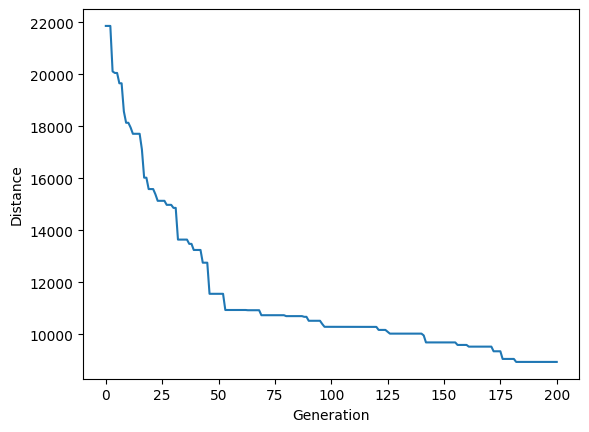

In [37]:
genetic_algorithm_plot(population=cityList, population_size=100, elite_size=20, mutation_rate=0.01, generations=200, crossover_function=OX1_crossover, mutator_function=DM_mutate)

## Run with different operators

In [38]:
crossover_functions = {
    OX1_crossover: "OX1",
    POS_crossover: "POS",
    ER_crossover: "ER",
}
mutation_functions = {
    DM_mutate: "DM",
    ISM_mutate: "ISM",
    IVM_mutate: "IVM",
}
results = {}
for mutation_function, mutation_function_name in mutation_functions.items():
    for crossover_function, crossover_function_name in crossover_functions.items():
        print(f'calculating for {mutation_function_name} {crossover_function_name}')
        algorithm_output = genetic_algorithm(population=cityList, population_size=100, elite_size=20, mutation_rate=0.07, generations=200, crossover_function=crossover_function, mutator_function=mutation_function)
        results[f'{mutation_function_name}-{crossover_function_name}'] = algorithm_output
        print('done')

import json
print(json.dumps(results,indent=1))